In [15]:
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")
%matplotlib inline

mpl.rcParams["savefig.dpi"] = 200
# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
uncalibrated_base_dir = Path("..")/"../uncalibrated_data/"
calibration_curve_base_dir = Path("..")/"../calibration_curve/"
calibrated_table_dir = Path("..")/"../tables/"
minstop_table_dir = Path("..")/"../minstop_calibrate_full_tables/"
largeprior_table_dir = Path("..")/"../xtreme_prior_full_tables/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

In [18]:
legend_order = ['bravo    | p=0.7 ',
                'bravo    | p=0.55 ',
                'bravo    | p=0.52 ',
                'bravo    | p=0.51 ',
                'bravo_without_replacement | p=0.7 ',
                'bravo_without_replacement | p=0.55 ',
                'bravo_without_replacement | p=0.52 ',
                'bravo_without_replacement | p=0.51 ',
                'bayesian | a=1 | b=1 ',
                'bayesian | a=100 | b=100 ',
                'bayesian | a=500 | b=500 ',
                'bayesian | a=1000 | b=1000 ',
                'bayesian_with_replacement | a=1 | b=1 ',
                'truncated_bayesian | a=1 | b=1 ',
                'clip     ', 
                'max_sprt ']

def get_position(name):
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        print(name)
        assert False

def reorder_df(df):
    return df.loc[sorted(df.index, key=get_position)]

mpl.rcParams["figure.figsize"] = [8, 6]

def read_csv(file_path, reorder=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.set_index('legend', inplace=True)
    if reorder:
        df = reorder_df(df)
    return df.reset_index()

def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

def make_legend(df, ax, outside=False, *args, **kwargs):
    if outside:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 *args, **kwargs)
    else:
        ax.legend(labels=[basename+" "+parameter for i, (basename, parameter) in 
                          df[['basename_with_type', 'parameter']].drop_duplicates()
                          .iterrows()], *args, **kwargs)

In [19]:
cols = sns.color_palette("bright", 6)
cs_dict = {'bayesian | a=1 | b=1':cols[0],
           'bayesian_with_replacement | a=1 | b=1':cols[0],
           'bravo    | p=0.55':cols[1],
           'bravo    | p=0.7':cols[1],
           'bravo_without_replacement | p=0.55':cols[2],
           'bravo_without_replacement | p=0.7':cols[2],
           'clip    ':cols[3], 
           'max_sprt':cols[4],
           'truncated_bayesian | a=1 | b=1':cols[5]}

# ls_dict = {'bayesian | a=1 | b=1':'-',
#            'bayesian_with_replacement | a=1 | b=1':'--',
#            'bravo    | p=0.55':'-',
#            'bravo    | p=0.7':'--',
#            'bravo_without_replacement | p=0.55':'-',
#            'bravo_without_replacement | p=0.7':'--',
#            'clip    ':'--', 
#            'max_sprt':'--',
#            'truncated_bayesian | a=1 | b=1':'--'}
ls_dict = {'bayesian | a=1 | b=1':'-',
           'bayesian_with_replacement | a=1 | b=1':'-',
           'bravo    | p=0.55':'-',
           'bravo    | p=0.7':'-',
           'bravo_without_replacement | p=0.55':'-',
           'bravo_without_replacement | p=0.7':'-',
           'clip    ':'-', 
           'max_sprt':'-',
           'truncated_bayesian | a=1 | b=1':'-'}

ms_dict = {'bayesian | a=1 | b=1':'o',
           'bayesian_with_replacement | a=1 | b=1':'s',
           'bravo    | p=0.55':'<',
           'bravo    | p=0.7':'>',
           'bravo_without_replacement | p=0.55':'P',
           'bravo_without_replacement | p=0.7':'X',
           'clip    ':'o', 
           'max_sprt':'o',
           'truncated_bayesian | a=1 | b=1':'o'}

In [20]:
def map_styles(legends):
    cs, ls, ms = [], [], []
    for legend in legends:
        legend = legend.rsplit(" | ", 1)[0]
        ls.append(ls_dict[legend])
        cs.append(cs_dict[legend])
        ms.append(ms_dict[legend])
    return cs, ls, ms

In [21]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

filled_markers = (
    'o', 'v', '^', 
    
    '<', '>', '*', 
    
    's', '8', 
    
    'H', 
    
    'D', 
    
    'X')
dash_styles = [
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (5, 1, 1, 1),
    
    (2, 2, 3, 1.5),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
]

In [22]:
def prep_long_df(df):
    if 'legend' not in df.columns:
        df = df.reset_index()
    data_long = pivot_widetable(df, [], [], id_vars='legend', var_name='p', value_name='expected_sample')
    types = data_long.legend.apply(group_type)
    basenames = data_long.legend.apply(group_basename)
    parameters = data_long.legend.apply(group_parameter)
    basenames_with_type = data_long.legend.apply(group_basename_with_type)
    parameters_with_type = data_long.legend.apply(group_parameter_with_type)
    data_long['type'] = types
    data_long['basename'] = basenames
    data_long['basename_with_type'] = basenames_with_type
    data_long['parameter'] = parameters
    data_long['parameter_with_type'] = parameters_with_type
    return data_long

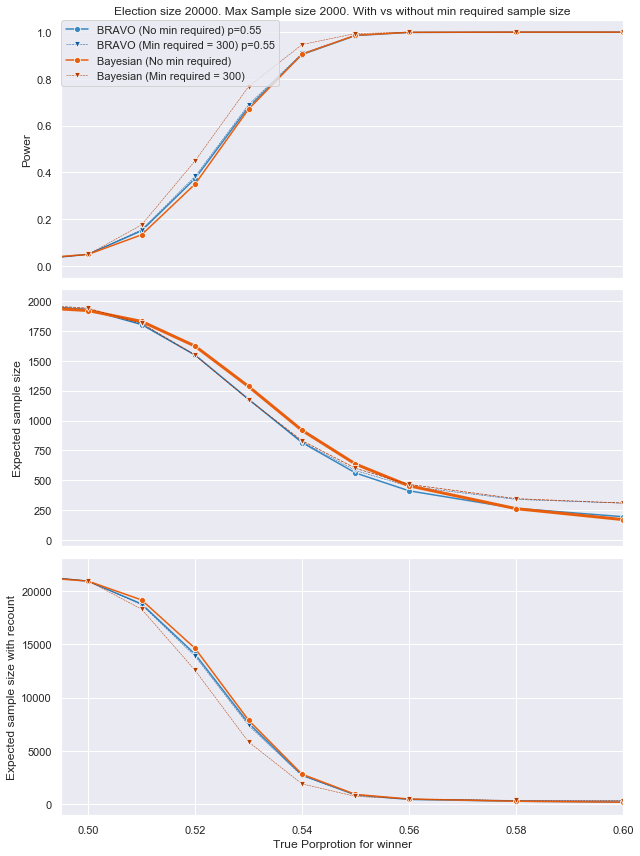

In [47]:
# 3. Comparison between calibration and uncalibration
# Specifically made for expected count for bravo
# data
election = Election(20000, 2000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
_ax = ax
ax.set_title("Election size 20000. Max Sample size 2000. With vs without min required sample size")

data_type = "power.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = minstop_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55"'),
             data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55,min_stop=300"')])
# data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and (parameter == "p=0.55" or parameter == "p=0.51")'),
#              data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55,min_stop=300"')])


sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Blues", 5)[-2:], 
    legend=False, 
    ax=ax)

data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = minstop_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "Bayesian (BetaBinomial)"'),
             data_long2.query('basename_with_type == "Bayesian (BetaBinomial)"')])

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Oranges", 5)[-2:], 
    legend=False, 
    ax=ax)
ax.set_ylabel("Power")
ax.set_xlim([0.495, 0.6])
ax.xaxis.set_visible(False)


# data
ax = fig.add_subplot(312)

data_type = "unconditional_mean.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = minstop_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55"'),
             data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55,min_stop=300"')])
# data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and (parameter == "p=0.55" or parameter == "p=0.51")'),
#              data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55,min_stop=300"')])


sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Blues", 5)[-2:], 
    legend=False, 
    ax=ax)

data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = minstop_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "Bayesian (BetaBinomial)"'),
             data_long2.query('basename_with_type == "Bayesian (BetaBinomial)"')])

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Oranges", 5)[-2:], 
    legend=False, 
    ax=ax)
ax.set_ylabel("Expected sample size")
ax.set_xlim([0.495, 0.6])
ax.xaxis.set_visible(False)



# data
ax = fig.add_subplot(313)
data_type = "unconditional_mean_with_recount.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = minstop_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55"'),
             data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55,min_stop=300"')])
# data_long = pd.concat([data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and (parameter == "p=0.55" or parameter == "p=0.51")'),
#              data_long2.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55,min_stop=300"')])


sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Blues", 5)[-2:], 
    legend=False, 
    ax=ax)

data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = minstop_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "Bayesian (BetaBinomial)"'),
             data_long2.query('basename_with_type == "Bayesian (BetaBinomial)"')])

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Oranges", 5)[-2:], 
    legend=False, 
    ax=ax)
ax.set_ylabel("Expected sample size with recount")
ax.set_xlabel("True Porprotion for winner")
ax.set_xlim([0.495, 0.6])

plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
_ax.legend(['BRAVO (No min required) p=0.55', 'BRAVO (Min required = 300) p=0.55', 'Bayesian (No min required)', 'Bayesian (Min required = 300)'], bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/minstop_cmp_20000.png')

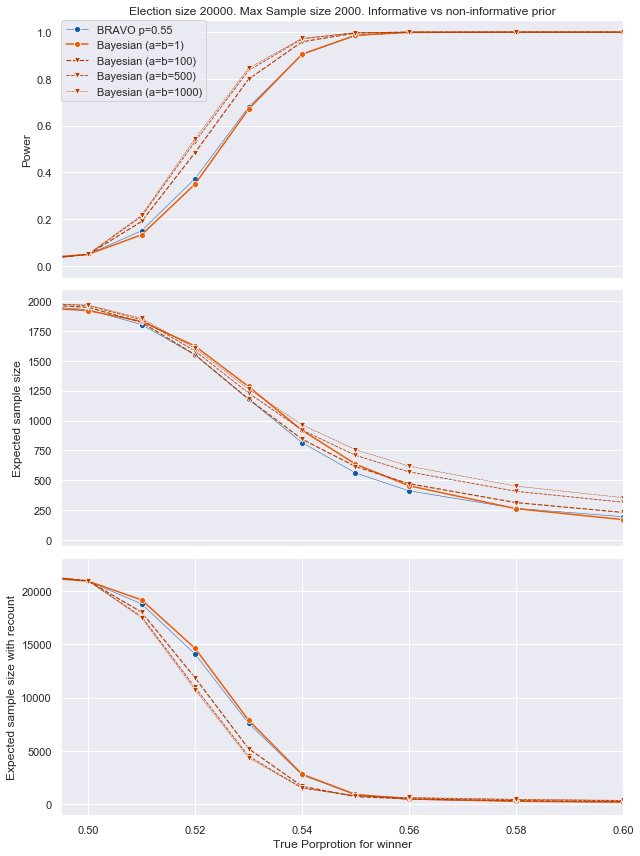

In [48]:
# 4. Comparison between informative and non-informative prior
# data
election = Election(20000, 2000, 0.5, 1, False)
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
ax.set_title("Election size 20000. Max Sample size 2000. Informative vs non-informative prior")

data_type = "power.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 

data_long = data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55"')

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette("Blues", 5)[-1:], 
    sizes=(0.5, 1.5),
    legend=False, 
    ax=ax)


data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = largeprior_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "Bayesian (BetaBinomial)"'),
             data_long2.query('basename_with_type == "Bayesian (BetaBinomial)"')])

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette("Oranges", 5)[-2:], 
    sizes=(0.5, 1.5),
    legend=False, 
    ax=ax)
ax.set_ylabel("Power")
ax.set_xlim([0.495, 0.6])
ax.xaxis.set_visible(False)
_ax = ax



# data
ax = fig.add_subplot(312)

data_type = "unconditional_mean.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 

data_long = data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55"')

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Blues", 5)[-1:], 
    legend=False, 
    ax=ax)


data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = largeprior_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "Bayesian (BetaBinomial)"'),
             data_long2.query('basename_with_type == "Bayesian (BetaBinomial)"')])

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Oranges", 5)[-2:], 
    legend=False, 
    ax=ax)
ax.set_ylabel("Expected sample size")
ax.set_xlim([0.495, 0.6])
ax.xaxis.set_visible(False)



# data
ax = fig.add_subplot(313)
data_type = "unconditional_mean_with_recount.csv"
data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 

data_long = data_long1.query('basename_with_type == "BRAVO (Hypergeometric)" and parameter == "p=0.55"')

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Blues", 5)[-1:], 
    legend=False, 
    ax=ax)


data_path1 = calibrated_table_dir/str(election)/data_type
data_long1 = prep_long_df(read_csv(data_path1))
data_long1['minstop'] = False 
data_path2 = largeprior_table_dir/str(election)/data_type
data_long2 = prep_long_df(read_csv(data_path2))
data_long2['minstop'] = True 

data_long = pd.concat([data_long1.query('basename_with_type == "Bayesian (BetaBinomial)"'),
             data_long2.query('basename_with_type == "Bayesian (BetaBinomial)"')])

sns.lineplot(
    x = 'p',
    y = 'expected_sample',
    hue = 'minstop',
    style= 'minstop',
    size= 'parameter',
    data=data_long,
    markers=filled_markers, 
    dashes=dash_styles,
    sizes=(0.5, 1.5),
    palette=sns.color_palette("Oranges", 5)[-2:], 
    legend=False, 
    ax=ax)
ax.set_ylabel("Expected sample size with recount")
ax.set_xlabel("True Porprotion for winner")
ax.set_xlim([0.495, 0.6])

plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
_ax.legend(['BRAVO p=0.55', 
            'Bayesian (a=b=1)', 
            'Bayesian (a=b=100)',
            'Bayesian (a=b=500)',
            'Bayesian (a=b=1000)',
           ], bbox_to_anchor=(0,1), loc=2, borderaxespad=0.)
plt.savefig('../../figures/informative_cmp_20000.png')